# Add Frameworks and Libraries

In [0]:
# Import libraries
import os
import pandas as pd
import pickle
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from google.colab import drive

# Setup Environments

In [31]:
# nltk, plt setup
nltk.download('punkt')
%matplotlib inline

# drive setup
drive.mount('/content/drive')
dataset_url = "/content/drive/My Drive/NCKUDMPH2/task1/dataset/"
program_url = "/content/drive/My Drive/NCKUDMPH2/task1/program/"

# setup gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup Hyperparameters

In [0]:
embedding_dim = 300
hidden_dim = 512
learning_rate = 1e-4
max_epoch = 15
batch_size = 64
threshold = 0.4

# Load Data and split it into Train/Dev/Test

In [0]:
dataset = pd.read_csv(dataset_url+'super_trainset.csv', dtype=str)

# Drop unuse columns
# dataset.drop('Title',axis=1,inplace=True)
# dataset.drop('Categories',axis=1,inplace=True)
# dataset.drop('Created Date',axis=1, inplace=True)
# dataset.drop('Authors',axis=1,inplace=True)

# Data Partition
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=2020)

trainset.to_csv(dataset_url+'trainset.csv',index=False)
validset.to_csv(dataset_url+'validset.csv',index=False)

# Test Data
dataset = pd.read_csv(dataset_url+'task1_public_testset.csv')
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

dataset.to_csv(dataset_url+'testset.csv',index=False)

# Helpers

## Tokenize Helpers

In [0]:
# tokenize the words
def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

## Data Formatting Helpers

In [0]:
def label_to_onehot(labels):
    label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot

def sentence_to_indices(sentence, word_dict):
    return [word_dict.get(word,UNK_TOKEN) for word in word_tokenize(sentence)]

def get_dataset(data_path, word_dict, n_workers=4):
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
        
    return processed

## Data Packing Helpers

In [0]:
# Data Packing
class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            # gather labels
            if 'Label' in data:
                pad_label = data['Label']
                pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
                
                batch_label.append(pad_label)
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

## Score Helpers

In [0]:
# Score methods
class F1():
    def __init__(self):
        self.threshold = threshold
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)

## Train Helpers

In [0]:
# Train helpers
def _run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, collate_fn=dataset.collate_fn, num_workers=8)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
        del o_labels, batch_loss # Flush memory

    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    l_loss = (l_loss * sample_weights).mean()
    del abstract, labels  # flush
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists(program_url+'model'):
        os.makedirs(program_url+'model')
    torch.save(model.state_dict(), program_url+'model/model.pkl.'+str(epoch))
    with open(program_url+'model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

## Submit Helpers

In [0]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

# Data-Preprocessing

In [0]:
# Create a word dictionary
PAD_TOKEN = 0
UNK_TOKEN = 1

if os.path.exists(program_url+'dicitonary.pkl'):
    with open(program_url+'dicitonary.pkl','rb') as f:
        word_dict = pickle.load(f)
else:
    words = set()
    words |= collect_words(dataset_url+'trainset.csv')

    word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
    for word in words:
        word_dict[word]=len(word_dict)

    with open(program_url+'dicitonary.pkl','wb') as f:
        pickle.dump(word_dict, f)

In [42]:
# Get 3 datasets
print('[INFO] Start processing trainset...')
train = get_dataset(dataset_url+'trainset.csv', word_dict, n_workers=8)
print('[INFO] Start processing validset...')
valid = get_dataset(dataset_url+'validset.csv', word_dict, n_workers=8)
print('[INFO] Start processing testset...')
test = get_dataset(dataset_url+'testset.csv', word_dict, n_workers=8)

[INFO] Start processing trainset...


100%|██████████| 3037/3037 [00:19<00:00, 152.52it/s]


[INFO] Start processing validset...


100%|██████████| 341/341 [00:02<00:00, 163.36it/s]


[INFO] Start processing testset...


100%|██████████| 2500/2500 [00:15<00:00, 159.85it/s]


In [0]:
trainData = AbstractDataset(train, PAD_TOKEN, max_len = 128)
validData = AbstractDataset(valid, PAD_TOKEN, max_len = 128)
testData = AbstractDataset(test, PAD_TOKEN, max_len = 128)
del trainset, validset, dataset, train, valid, test

# handle data imbalance problem in training


In [0]:
def squeeze_sample_weights(sample_weights):
    sample_weights = np.array(sample_weights)
    return np.mean(sample_weights, axis=0)

sample_weights = [compute_sample_weight(class_weight='balanced', y=abstract_labels) for data in trainData.data for abstract_labels in data['Label']]
sample_weights = np.array(sample_weights)
sample_weights = squeeze_sample_weights(sample_weights)
sample_weights = torch.tensor(sample_weights).to(device)

# Create GloVe Embedding vectors

In [0]:
glove_name = 'glove.840B.300d'

if os.path.exists(program_url+'embedding_matrix_{}'.format(glove_name)):
    with open(program_url+'embedding_matrix_{}'.format(glove_name),'rb') as f:
        embedding_matrix = pickle.load(f)
else:
    # Parse the unzipped file (a .txt file) to build an index that maps 
    # words (as strings) to their vector representation (as number vectors)
    wordvector_path = dataset_url+'glove/{}.txt'.format(glove_name)
    embeddings_index = {}
    f = open(wordvector_path, encoding='utf8')
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    # Preparing the GloVe word-embeddings matrix
    max_words = len(word_dict)
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_dict.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_matrix = torch.FloatTensor(embedding_matrix)
    with open(program_url+'embedding_matrix_{}'.format(glove_name),'wb') as f:
        pickle.dump(embedding_matrix, f)

# Create Nets

In [0]:
class GloVeNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(GloVeNet, self).__init__()
        self.embedding_size = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
        self.embedding.weight = torch.nn.Parameter(embedding_matrix)
        self.word_rnn = nn.GRU(self.embedding_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        self.sent_rnn = nn.GRU(self.hidden_dim*2, self.hidden_dim, bidirectional=True, batch_first=True)
        
        # 1024 => 512
        self.l1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        torch.nn.init.kaiming_normal_(self.l1.weight)
        # 512 => 6
        self.l2 = nn.Linear(self.hidden_dim, 6)
    

    def forward(self, x):
        # input 32, 11, 64
        x = self.embedding(x)  # emb 32, 11, 64, 300
        b,s,w,e = x.shape
        x = x.view(b,s*w,e)  # sent*word 32, 704, 300
        x, __ = self.word_rnn(x)  # rnn 32, 704, 1024
        x = x.view(b,s,w,-1)  # unwrap sw 32, 11, 64, 1024
        # 32 batch, 11 sentence, each 64 words
        x = torch.max(x,dim=2)[0]  # 32, 11, 1024
        x, __ = self.sent_rnn(x)  # 32, 11, 1024
        x = torch.relu(self.l1(x))  # 32, 11, 512
        x = torch.sigmoid(self.l2(x)) # 32, 11, 6
        return x

# Start Learning

In [47]:
model = GloVeNet(len(word_dict))
opt = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
criteria = torch.nn.BCELoss(reduction='none')
model.to(device)
history = {'train':[],'valid':[]}

for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, True)
    _run_epoch(epoch, False)
    save(epoch)

Epoch: 0


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.91it/s, f1=0.82876, loss=0.0965]


Epoch: 1


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.80it/s, f1=0.87094, loss=0.0793]


Epoch: 2


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.72it/s, f1=0.87303, loss=0.075]


Epoch: 3


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.77it/s, f1=0.88536, loss=0.0661]


Epoch: 4


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.81it/s, f1=0.85881, loss=0.0807]


Epoch: 5


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.89it/s, f1=0.89727, loss=0.061]


Epoch: 6


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.72it/s, f1=0.89056, loss=0.0628]


Epoch: 7


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.73it/s, f1=0.88792, loss=0.0646]


Epoch: 8


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.79it/s, f1=0.89722, loss=0.0596]


Epoch: 9


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.86it/s, f1=0.89387, loss=0.0622]


Epoch: 10


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.73it/s, f1=0.89858, loss=0.0591]


Epoch: 11


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.79it/s, f1=0.89840, loss=0.0596]


Epoch: 12


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.81it/s, f1=0.89797, loss=0.0604]


Epoch: 13


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.79it/s, f1=0.89315, loss=0.0617]


Epoch: 14


Valid: 100%|██████████| 43/43 [00:04<00:00,  9.77it/s, f1=0.89381, loss=0.0616]


## Plot Learning Result

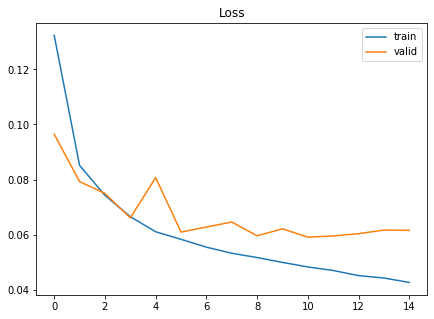

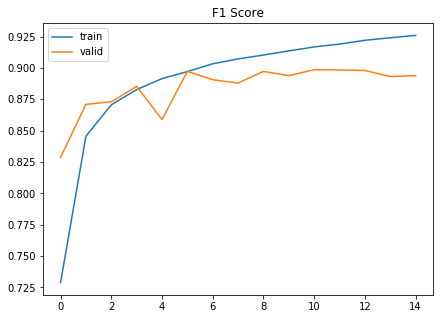

Best Loss score  [0.05914067366242417, 10]
Best F1 score  [0.8985812839494854, 10]


In [48]:
with open(program_url+'model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best Loss score ', min([[l['loss'], idx] for idx, l in enumerate(history['valid'])]))
print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

# Start Predicting

In [49]:
best_model = 10
model.load_state_dict(state_dict=torch.load(os.path.join(program_url,'model/model.pkl.{}'.format(best_model))))
_run_epoch(1, False)

# Use trained model to predict
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=8)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
    o_labels = model(x.to(device))
    result = o_labels > threshold
    
    # for i in range(len(result)):
    #     for j in range(len(result[i])):
    #         if not result[i][j].any():
    #             result[i][j] = torch.max(o_labels[i][j]) == o_labels[i][j]

    for idx, o_label in enumerate(result):
        prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

Predict: 100%|██████████| 313/313 [00:32<00:00,  9.67it/s]


## Submit Prediction Results

In [0]:
SubmitGenerator(prediction,
                dataset_url+'task1_sample_submission.csv', 
                True, 
                dataset_url+'task1_submission.csv')

# Make Testset Great Again

In [0]:
def onehot_to_label(row):
    b = "BACKGROUND" if row['BACKGROUND'] == 1 else ""
    o = "OBJECTIVES" if row['OBJECTIVES'] == 1 else ""
    m = "METHODS" if row['METHODS'] == 1 else ""
    r = "RESULTS" if row['RESULTS'] == 1 else ""
    c = "CONCLUSIONS" if row['CONCLUSIONS'] == 1 else ""
    ot = "OTHERS" if row['OTHERS'] == 1 else ""
    return "/".join(filter(None, [b, o, m, r, c, ot]))

test = pd.read_csv(dataset_url+'task1_submission.csv')

test['index'] = test["order_id"].str.split("_")
test['index'] = test['index'].str[0]

df = pd.DataFrame(columns=['Id', 'Task 1'])
for index, row in tqdm(test.iterrows()):
    row_index = row['index']
    row_label = onehot_to_label(row)
    if df['Id'].isin([row_index]).any():
        df.loc[df['Id'] == row_index, ['Task 1']] = df.loc[df['Id'] == row_index]['Task 1'] + " " + row_label
    else:
        df = df.append({'Id': row_index, 'Task 1': row_label}, ignore_index=True)

df.head()

In [0]:
df2 = df.iloc[:20000]
testset = pd.read_csv(dataset_url+'testset.csv')

trainset = pd.read_csv(dataset_url+'task1_trainset.csv', dtype=str)

# Drop unuse columns
trainset.drop('Title',axis=1,inplace=True)
trainset.drop('Categories',axis=1,inplace=True)
trainset.drop('Created Date',axis=1, inplace=True)
trainset.drop('Authors',axis=1,inplace=True)

test_train_set = testset.merge(df2, on='Id')
test_train_set = pd.concat([trainset, test_train_set], ignore_index=True)
test_train_set.to_csv(dataset_url+'super_trainset.csv',index=False)